In [1]:
# TODO: 
# 1. check that the order of the RDM for each individual views for models
# 2. do pre-learning and post-learning

In [1]:
from __future__ import division

import numpy as np
import os
from glob import glob
import scipy
import pickle
import utils

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd

In [2]:
FURNITURES = ['bed', 'bench', 'chair', 'table']
LAYERS = {'pool1': 0, 'pool2': 1, 'pool3': 2, 'pool4': 3,
          'pool5': 4, 'fc6': 5, 'fc7': 6} # 'prob': 7} taking out probability layer for now. 
FURNITURES_label = ['bedChair_1', 'bedChair_100', 'tableBench_1', 'tableBench_100']

LAYERS_NM = ['pixel', 'pool1', 'pool2', 'pool3', 'pool4', 'pool5', 'fc6', 'fc7']
VGG_SIZE_X = 224
VGG_SIZE_Y = 224
VGG_SIZE_Z = 3

NUM_VIEWS = 40
NUM_VIEWS_S = 20

In [3]:
# pulling/cleaning up the data

# downloading the activations. I had to split the sample (each act has 160 images) because they're about 3GB each. 
SF = pickle.load(open('/tigress/rslee/SF.p', 'rb'))
MF = pickle.load(open('/tigress/rslee/DF.p', 'rb'))

In [38]:
# get labels
def list_files(path, ext='png'):
    result = [y for x in os.walk(path)
              for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

def get_label_from_path(path):
    return path.split('.')[-2].split('_')[-1]    

def get_trial_from_path(path):
    return path.split('_')[-2]

def get_subj_from_path(path):
    return path.split('/')[-2]

def get_trial_ID_from_path(path):
    return path.split('/')[-1].split('.')[0]

def get_viewpoint_from_path(path):
    return path.split('_')[3].split('.')[0]
    
# extract metadata
path_to_sketches = '/home/rslee/sketch_data'
sketch_paths = list_files(path_to_sketches)
sketch_labels = map(get_label_from_path,sketch_paths)
trialNum = map(get_trial_from_path,sketch_paths)
subj = map(get_subj_from_path,sketch_paths)
trialID = map(get_trial_ID_from_path, sketch_paths)

path_to_models = '/home/rslee/object_data'
model_paths = list_files(path_to_models, ext='png') 
model_labels = [p.split('/')[-2] for p in model_paths]
model_viewpoints = map(get_viewpoint_from_path, model_paths)


# organize into dataframe
S = pd.DataFrame([subj,trialNum,sketch_labels,sketch_paths, trialID])
S = S.transpose()
S.columns = ['subj','trial','label','path','trialID']


M = pd.DataFrame([model_labels,model_paths, model_viewpoints])
M = M.transpose()
M.columns = ['label','path', 'viewpoint']

print 'Number of sketches: ' + str(len(sketch_paths))
print 'Number of subjects: ' + str(len(np.unique(subj)))


print 'Number of models: ' + str(len(model_paths))
num_models = len(model_paths)
num_sketches = len(sketch_paths)

Number of sketches: 1380
Number of subjects: 35
Number of models: 320


In [27]:


def get_trial_ID_from_metadata(path):
    metadata = pd.read_csv(path)[['wID', 'trial','target']]
    trialID = ["%s_trial_%s_%s" % (metadata['wID'].values[row], metadata['trial'].values[row], metadata['target'].values[row])
               for row in xrange(0,len(metadata))]
    return trialID

def get_viewpoint_from_metadata(path):
    return pd.read_csv(path).viewpoint.values.tolist()

metadata_paths = list_files(path_to_sketches, ext='csv') 
trialID_metadata = sum(map(get_trial_ID_from_metadata, metadata_paths), [])
viewpoint_sketches = np.asarray(sum(map(get_viewpoint_from_metadata, metadata_paths),[]))

print 'Number of metadata files: ' + str(len(metadata_paths))
print 'Number of metadata trials for models: ' + str(len(viewpoint_sketches))


Number of metadata files: 35
Number of metadata trials for models: 1380


In [28]:
# getting the metadata to be sorted correctly. 

inds_metadata = np.argsort(trialID_metadata)
_trialID_metadata = np.asarray(trialID_metadata)[inds_metadata]
_SVP_bt = np.asarray(viewpoint_sketches)[inds_metadata]


In [29]:
SL = np.array(sketch_labels)
## normalize and get means of feature vectors

def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):
    # load in and normalize features 
    X = normalize(X)
    _mu = np.zeros((len(np.unique(np.asarray(labels))), X.shape[1]), float)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu


def get_means_across_views(X, labels, viewpoints): 
    _mu = np.zeros((len(np.unique(viewpoints)) * len(FURNITURES), X.shape[1]),float) # saving the averaged SF per laer here 
    for obj_i, obj in enumerate(FURNITURES):
        inds_object = np.where(labels == obj)
        X_obj = X[inds_object] # taking all the views per object here 
        
        means = get_class_means(X_obj, viewpoints[inds_object])
        
        _mu[obj_i * len(np.unique(viewpoints)): (obj_i + 1) * len(np.unique(viewpoints)), :] = means
    return _mu
        
_SF_bt = []
for layer in xrange(0,7):
    inds = np.argsort(S.trialID.values)
    SF_i = SF[layer]
    _SF_bt.append(SF_i[inds])
_SL_bt = SL[inds]



In [39]:
# getting pixel level data 

SP = np.empty((num_sketches, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z), float)
SP_i = 0 # used for the batch index 
for path in sketch_paths: 
    img = utils.load_image(path)
    # take out the fourth dimension, alpha, which controls transparency
    img = img[:,:,:3]

    img = np.asarray(img.flatten()).reshape(1, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z)
          
    SP[SP_i, :] = img
    SP_i += 1 

inds = np.argsort(S.trialID.values)
_SP_bt = SP[inds]

MP = np.empty((num_models, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z), float)
MP_i = 0 # used for the batch index 
for path in model_paths: 
    img = utils.load_image(path)
    img = np.asarray(img.flatten()).reshape(1, VGG_SIZE_X * VGG_SIZE_Y* VGG_SIZE_Z)
        
    MP[MP_i, :] = img
    MP_i += 1 
        


In [33]:
# setting the index right for the sketches


inds_final = np.lexsort((_SVP_bt.astype(int), np.asarray(_SL_bt)))
_SVP = _SVP_bt[inds_final]
_SL = _SL_bt[inds_final]
_SP = _SP_bt[inds_final]
_SF = []
for layer in xrange(0,7):
    _SF_i = _SF_bt[layer]
    _SF.append(_SF_i[inds_final])

check1 = _trialID_metadata[inds_final]
check2 = S.trialID.values[np.argsort(S.trialID.values)][inds_final]

print _SVP[70:180]
print _SL[70:180]
print ("Checking that the indexing is correct: " + str(np.array_equal(check1, check2)))

[ 8  8  8  8  8  8  8  8  8  8 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 18
 18 18 18 18 18 18 18 18 18 18 18 18 18 18 18 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 22 22 22 22]
['bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed' 'bed'
 'bed' 

In [42]:
# setting the index right for the models

inds_final = np.lexsort((M.viewpoint.astype(int), M.label))
_MVP = np.asarray(model_viewpoints)[inds_final]
_ML = np.asarray(model_labels)[inds_final]
_MP = MP[inds_final]
_MF = []
for layer in xrange(0,7):
    _MF_i = MF[layer]
    _MF.append(_MF_i[inds_final])


print _MVP
print _ML


['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31'
 '32' '33' '34' '35' '36' '37' '38' '39' '0' '1' '2' '3' '4' '5' '6' '7'
 '8' '9' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '21' '22'
 '23' '24' '25' '26' '27' '28' '29' '30' '31' '32' '33' '34' '35' '36' '37'
 '38' '39' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '0' '1' '2' '3' '4' '5'
 '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20'
 '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12'
 '13' '14' '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27'
 '28' '29' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '0' '1' '2'
 '3' '4' '5' '6' '7' '8' 

In [43]:
# plot category-level similarity matrix
RDM_S = []
RDM_S.append(np.corrcoef(get_class_means(_SP, _SL)))
for layer in xrange(0,7):
    means = get_class_means(_SF[layer], _SL)
    RDM_S.append(np.corrcoef(means))


def get_furn(full):
    furn = full[0:NUM_VIEWS * 4]
    furn[-NUM_VIEWS:] = full[-NUM_VIEWS:]
    return furn
    

RDM_M = []
means = get_class_means(_MP, _ML)
means_furn = means[0:4]
means_furn[-1] = means[-1]
RDM_M.append(np.corrcoef(means_furn))
for layer in xrange(0,7):

    means = get_class_means(_MF[layer], _ML)
    means_furn = means[0:4]
    means_furn[-1] = means[-1]

    RDM_M.append(np.corrcoef(means_furn))

In [44]:
def plot_all_RDM(RDM, full=False, figure_name = ''):
    
    fig = plt.figure(1,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    
    plt.subplot(1, 6, 1)
    plt.title('Pixel Layer')
    plt.imshow(RDM[0], cmap= 'viridis', interpolation = 'none')
    
    if full == False:
        plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)
    
    for pool_layer in xrange(1,6):
        pltname = "Pool " + str(pool_layer)
        plt.subplot(1, 6, pool_layer + 1)
        plt.title(pltname)
        plt.imshow(RDM[pool_layer], cmap = 'viridis', interpolation='none')
        if full == True: 
            plt.xticks(np.arange(NUM_VIEWS_S/2, len(FURNITURES) * NUM_VIEWS_S, NUM_VIEWS_S), FURNITURES, rotation='vertical')

        else:
            plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')



    fig2 = plt.figure(2,  figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(121)
    plt.imshow(RDM[5], cmap = 'viridis', interpolation='none')
    plt.title("fc6")
    
    if full == True:
        plt.xticks(np.arange(NUM_VIEWS_S/2, len(FURNITURES) * NUM_VIEWS_S, NUM_VIEWS_S), FURNITURES, rotation='vertical')
        plt.yticks(np.arange(NUM_VIEWS_S/2, len(FURNITURES) * NUM_VIEWS_S, NUM_VIEWS_S), FURNITURES)
    else:
        plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
        plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)

    plt.subplot(122)
    plt.imshow(RDM[6],cmap = 'viridis', interpolation='none')
    plt.title("fc7")
    if full == True:
        plt.xticks(np.arange(NUM_VIEWS_S/2, len(FURNITURES) * NUM_VIEWS_S, NUM_VIEWS_S), FURNITURES, rotation='vertical')
        plt.yticks(np.arange(NUM_VIEWS_S/2, len(FURNITURES) * NUM_VIEWS_S, NUM_VIEWS_S), FURNITURES)
    else:
        plt.xticks(xrange(0,len(FURNITURES)), FURNITURES, rotation='vertical')
        plt.yticks(xrange(0,len(FURNITURES)), FURNITURES)

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.4])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    plt.colorbar(orientation='horizontal', ax=cax)
    plt.show()


## RDM of the 3D models

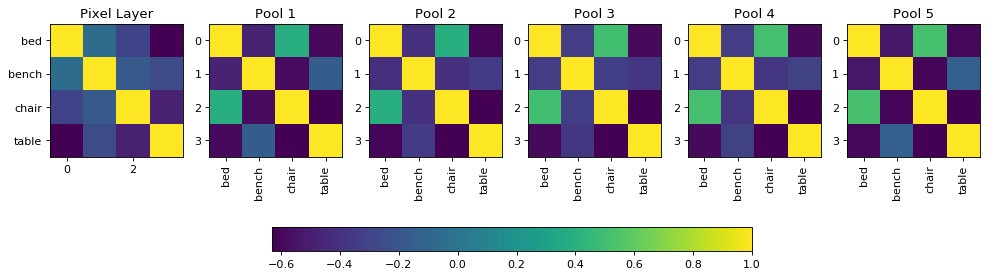

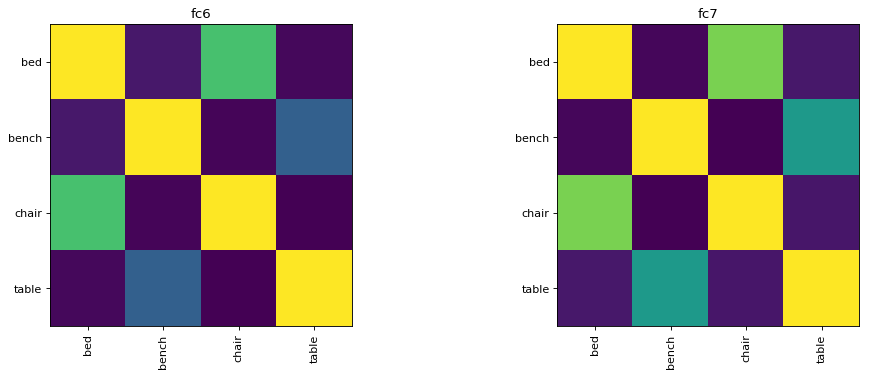

In [48]:
plot_all_RDM(RDM_M)

## RDM of the sketches

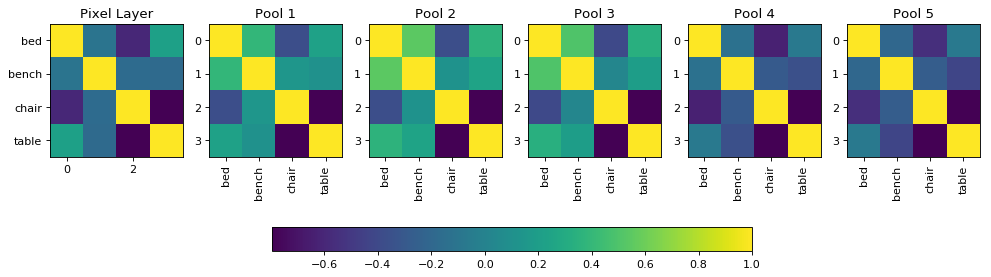

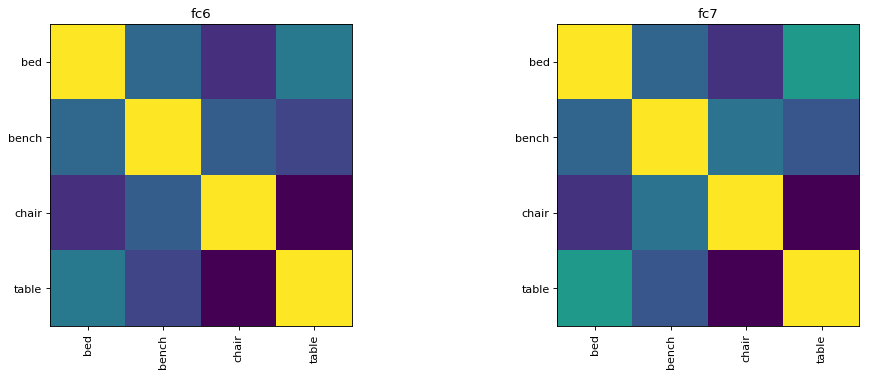

In [46]:


plot_all_RDM(RDM_S)

In [49]:

def get_off_diag(full):
    return full[np.triu_indices(4, 1)]
between_domains = []


for layer in xrange(0,8):
    between_domain_i = np.corrcoef(get_off_diag(RDM_S[layer]), get_off_diag(RDM_M[layer]))
    between_domains.append(between_domain_i[0, 1])
    print("pearson coefficient for between domains for layer " + str(layer) + " is " + str(between_domain_i[0, 1]))
    

pearson coefficient for between domains for layer 0 is -0.0291400250294
pearson coefficient for between domains for layer 1 is -0.178355292489
pearson coefficient for between domains for layer 2 is -0.189929808638
pearson coefficient for between domains for layer 3 is -0.187814645696
pearson coefficient for between domains for layer 4 is -0.29364591884
pearson coefficient for between domains for layer 5 is -0.305403707298
pearson coefficient for between domains for layer 6 is -0.340125097411
pearson coefficient for between domains for layer 7 is -0.268890394073


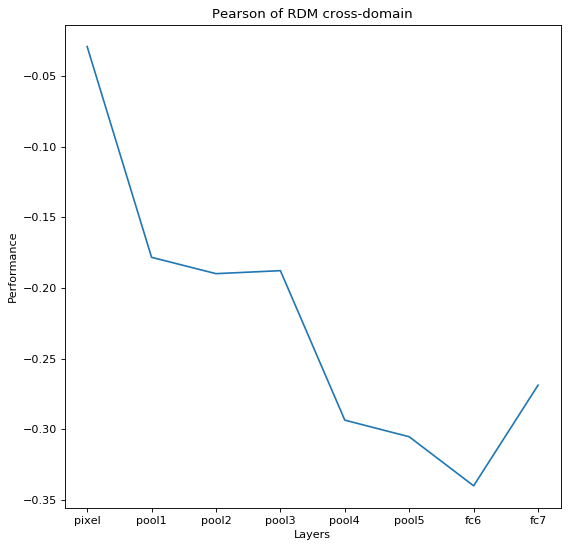

In [50]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

plt.title("Pearson of RDM cross-domain")
plt.plot(xrange(8), between_domains)
plt.xlabel('Layers')
plt.ylabel('Performance')



plt.xticks(xrange(0,len(LAYERS) + 1), LAYERS_NM);


In [51]:
# seperate out the furniture data and the even views only 

def get_furn(full):
    furn = full[0:NUM_VIEWS * 4]
    furn[-NUM_VIEWS:] = full[-NUM_VIEWS:]
    return furn[::2]
    
    
_MP_furn = get_furn(_MP)
_ML_furn = get_furn(_ML)

_MF_furn = []
for layer in xrange(0,7):
    _MF_furn.append(get_furn(_MF[layer]))
    
    
RDM_M_a = []
RDM_M_a.append(np.corrcoef(_MP_furn))
for layer in xrange(0,7):

    RDM_M_a.append(np.corrcoef(normalize(_MF_furn[layer])))

## RDM for 3D Models for each view

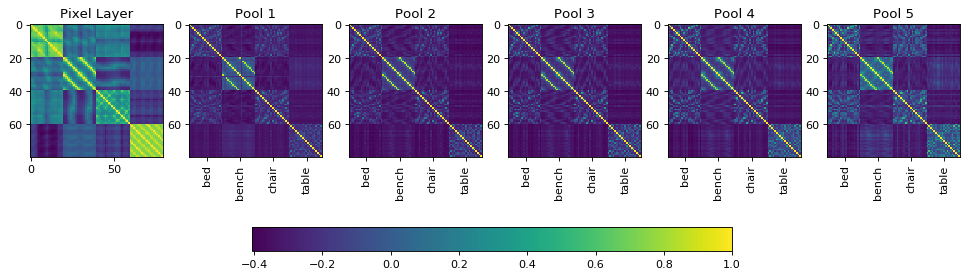

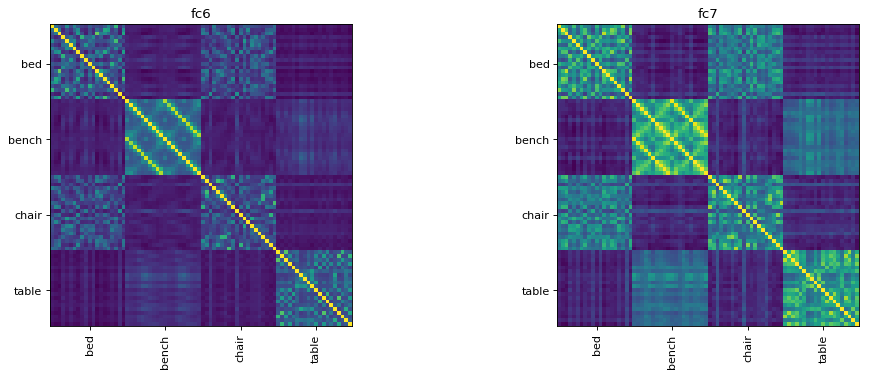

In [52]:
plot_all_RDM(RDM_M_a, full=True)

In [53]:
# plot RDM for all objects (no averaging) 
RDM_S_a = []
# need to fix pixel layer in a moment; RDM_S_a.append(np.corrcoef(_SP))
RDM_S_a.append(np.corrcoef(get_means_across_views(_SP, _SL, _SVP)))
for layer in xrange(0,7):
    
    RDM_S_a.append(np.corrcoef(get_means_across_views(_SF[layer], _SL, _SVP)))
    

foo = np.corrcoef(get_means_across_views(_SP, _SL, _SVP))

## RDM for Sketches for each view

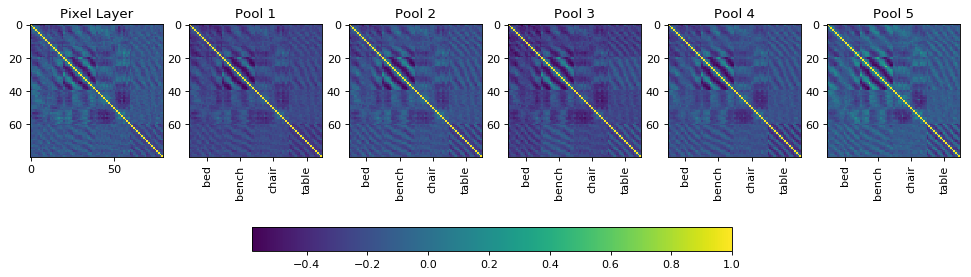

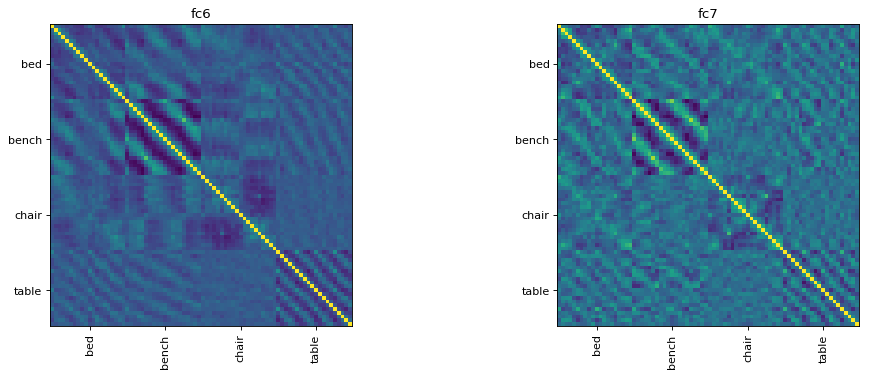

In [54]:
plot_all_RDM(RDM_S_a, full=True)

In [55]:

def get_off_diag(full):
    return full[np.triu_indices(4, 1)]
between_domains_all_views = []


for layer in xrange(0,8):
    between_domain_i = np.corrcoef(get_off_diag(RDM_S_a[layer]), get_off_diag(RDM_M_a[layer]))
    between_domains_all_views.append(between_domain_i[0, 1])
    print("pearson coefficient for between domains for layer " + str(layer) + " is " + str(between_domain_i[0, 1]))
    

pearson coefficient for between domains for layer 0 is 0.696204436108
pearson coefficient for between domains for layer 1 is 0.370217931364
pearson coefficient for between domains for layer 2 is 0.125767845171
pearson coefficient for between domains for layer 3 is -0.100597802849
pearson coefficient for between domains for layer 4 is 0.181808484478
pearson coefficient for between domains for layer 5 is 0.451618160483
pearson coefficient for between domains for layer 6 is 0.358631996365
pearson coefficient for between domains for layer 7 is 0.382215450755


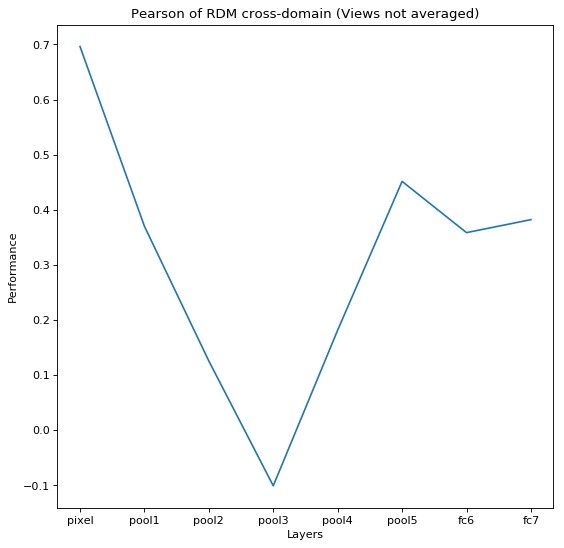

In [56]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

plt.title("Pearson of RDM cross-domain (Views not averaged)")
plt.plot(xrange(8), between_domains_all_views)
plt.xlabel('Layers')
plt.ylabel('Performance')



plt.xticks(xrange(0,len(LAYERS) + 1), LAYERS_NM);


# Logistic Regression

In [42]:

layer_score = []

# compute cross-validated softmax classifier accuracy 
# clf = svm.SVC(kernel='linear', C=1)

for i in reversed(xrange(0,7)):
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, _SF[i], _SL, cv=5)

    print("Accuracy for layer %f: %0.2f (+/- %0.2f)" % (i, scores.mean(), scores.std() * 2))
    layer_score.append(scores.mean) 


clf = linear_model.LogisticRegression(penalty='l2')
scores = cross_val_score(clf, _SP, _SL, cv=5)
print("Accuracy for pixel layer: %0.2f (+/- %0.2f)" % (i, scores.mean(), scores.std() * 2))
layer_score.append(scores.mean)
layer_score = reversed(layer_score)


Accuracy for layer 6.000000: 0.87 (+/- 0.05)
Accuracy for layer 5.000000: 0.88 (+/- 0.06)
Accuracy for layer 4.000000: 0.88 (+/- 0.06)
Accuracy for layer 3.000000: 0.82 (+/- 0.07)
Accuracy for layer 2.000000: 0.79 (+/- 0.09)
Accuracy for layer 1.000000: 0.75 (+/- 0.09)
Accuracy for layer 0.000000: 0.69 (+/- 0.10)


TypeError: append() takes exactly one argument (0 given)

In [101]:
layer_score.append(scores.mean)
print("Accuracy for pixel layer: %0.2f (+/- %0.2f)" % ( scores.mean(), scores.std() * 2))


Accuracy for pixel layer: 0.54 (+/- 0.08)


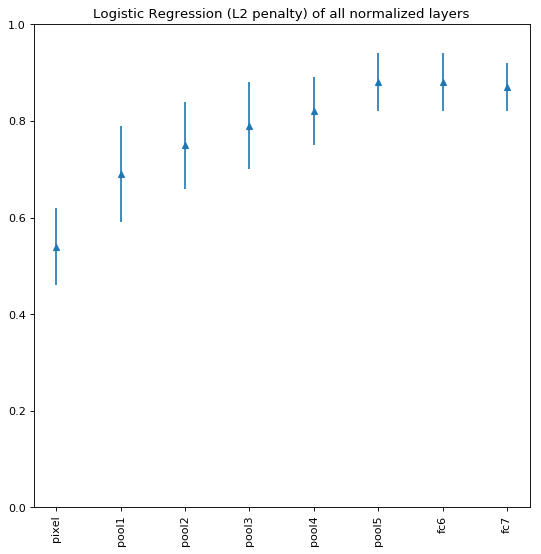

In [354]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

means = [0.54, 0.69, 0.75, 0.79, 0.82, 0.88, 0.88, 0.87]
stds = [0.08, 0.10, 0.09, 0.09, 0.07, 0.06, 0.06, 0.05]

plt.title('Logistic Regression (L2 penalty) of all normalized layers')
plt.errorbar(xrange(0, 8) , means, stds, linestyle='None', marker='^')
plt.ylim([0,1.0])


plt.xticks(xrange(0,8), LAYERS_NM, rotation='vertical');


In [ ]:
between_domains = []


for layer in xrange(0,8):
    between_domain_i = np.corrcoef(RDM_S[layer].flatten(), RDM_D[layer].flatten())
    between_domains.append(between_domain_i[0, 1])
    print("pearson coefficient for between domains for layer " + str(layer) + " is " + str(between_domain_i[0, 1]))
    

In [ ]:
# single train/test split

for i in reversed(xrange(0,7)):
    
    X_train, X_test, y_train, y_test = train_test_split(
        _SF[i], _SL, test_size=0.2, random_state=0)
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    print("Score for single trial is %0.2f" % clf.score(X_test, y_test))

clf = linear_model.LogisticRegression(penalty='l2')
scores = cross_val_score(clf, _SP, _SL, cv=5)
print("Score for single trial is %0.2f" % clf.score(X_test, y_test))

layer_score.append()
layer_score = reversed(layer_score)

Score for single trial is 0.85
Score for single trial is 0.90
Score for single trial is 0.91
Score for single trial is 0.89
Score for single trial is 0.81
Score for single trial is 0.77


In [125]:

layer_score = []
layer_std = []

# compute cross-validated softmax classifier accuracy 
# clf = svm.SVC(kernel='linear', C=1)

for i in reversed(xrange(0,7)):
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, _SF[i], _SL, cv=5)

    print("Accuracy for layer %f: %0.2f (+/- %0.2f)" % (i, scores.mean(), scores.std() * 2))
    layer_score.append(scores.mean()) 
    layer_std.append(scoers.std())


clf = linear_model.LogisticRegression(penalty='l2')
scores = cross_val_score(clf, _SP, _SL, cv=5)
print("Accuracy for pixel layer: %0.2f (+/- %0.2f)" % (i, scores.mean(), scores.std() * 2))
layer_score.append(scores.mean())
layer_std.append(scoers.std())
layer_score = reversed(layer_score)
layer_std = reversed(layer_std)



Accuracy for layer 6.000000: 0.87 (+/- 0.05)


NameError: name 'scoers' is not defined

# scrap

In [ ]:
plot_all_RDM(RDM_S_a)

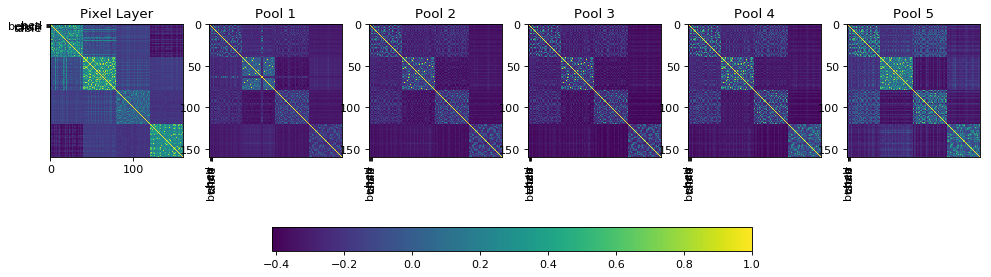

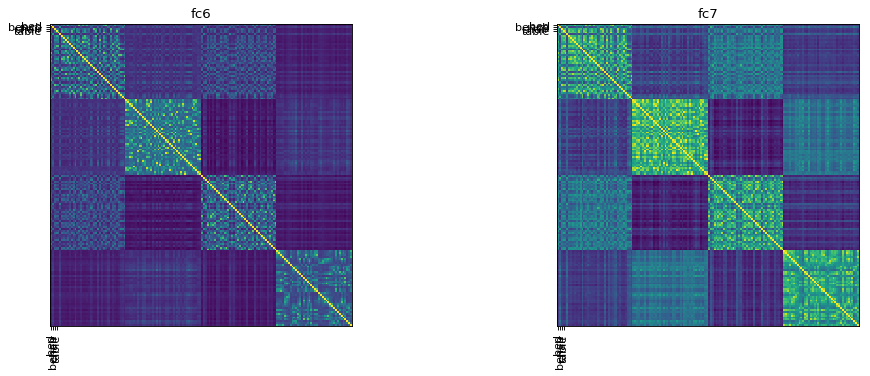

In [116]:
plot_all_RDM(RDM_D_a)

In [140]:
print _SL[63]
inds = np.argsort(DL)
sorted_paths = np.array(photo_paths)[inds]
sorted_paths[63]

bed


'/home/rslee/object_data/bench/tableBench_100_39.png.png'

In [26]:
raw_diff = []
for layer in xrange(0,8):
    raw_diff.append(np.mean(abs(RDM_S[layer] - RDM_D[layer])))

## comparing sketch features to model features

This isn't actualy the comparison we want. Features might be reprsented differently in later layers. It's not meaningful to look at how the features might be more similar in later layers

In [32]:
RDM_cross_full = [] # this will include all of the RDM info 
RDM_cross = []

cross = np.corrcoef(get_class_means(_SP, _SL), get_class_means(_MP_furn, _ML_furn))
RDM_cross_full.append(cross)
RDM_cross.append(cross[0:4, 4:8])

for layer in xrange(0,7):
    cross = np.corrcoef(get_class_means(_SF[layer], _SL), get_class_means(_MF_furn[layer], _ML_furn))
    RDM_cross_full.append(cross)
    RDM_cross.append(cross[0:4, 4:8])
    


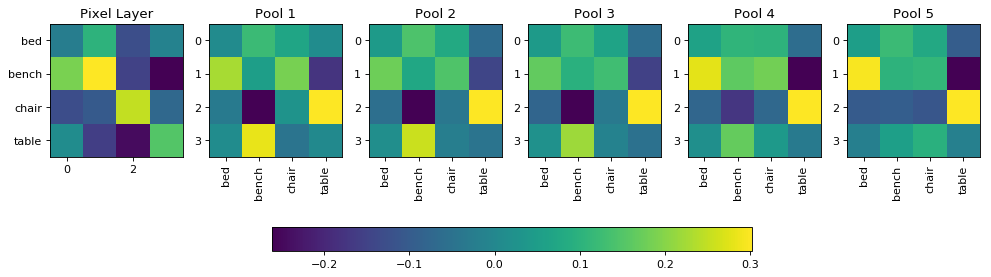

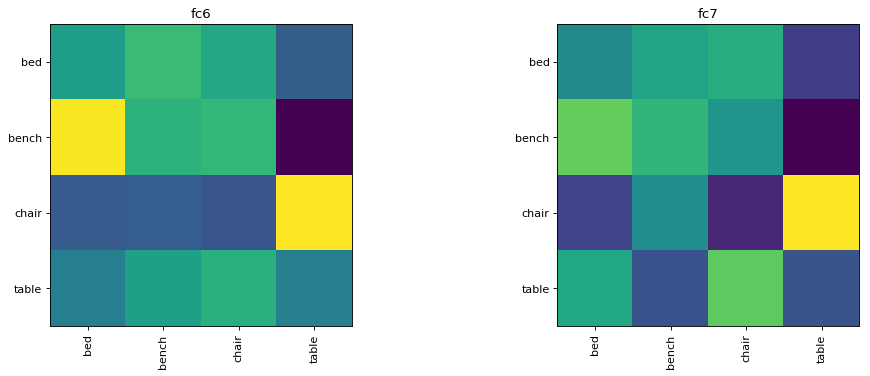

In [40]:
plot_all_RDM(RDM_cross)

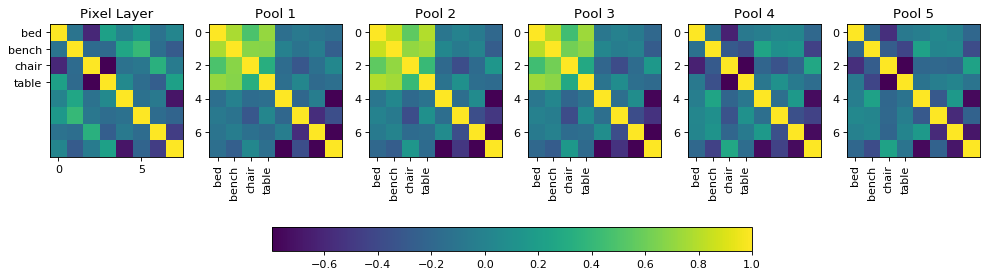

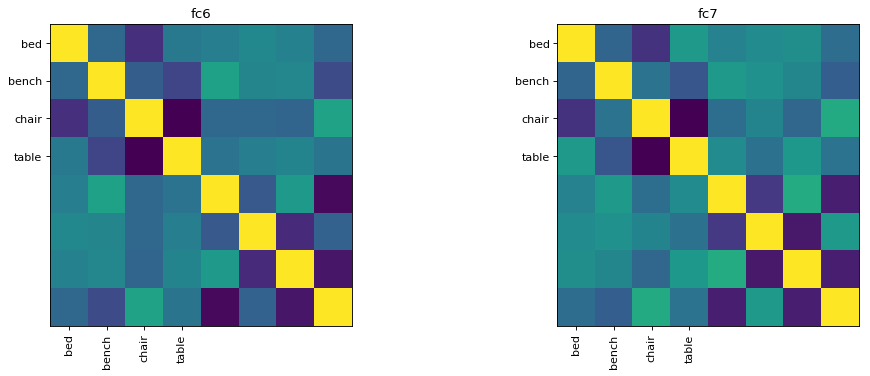

In [35]:
plot_all_RDM(RDM_cross_full)

In [59]:
between_domains = np.zeros((len(FURNITURES), len(LAYERS_NM)), float)


for layer in xrange(0,8):
    between_domains[:, layer] =  RDM_cross[layer].diagonal()
    print("pearson coefficient for between domains for layer " + str(layer) + " is " + str(between_domain_i))
    
    
print between_domains.shape
    

pearson coefficient for between domains for layer 0 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 1 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 2 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 3 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 4 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 5 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 6 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
pearson coefficient for between domains for layer 7 is [ 0.06768494  0.05575573 -0.29020029 -0.20711528]
(4, 8)


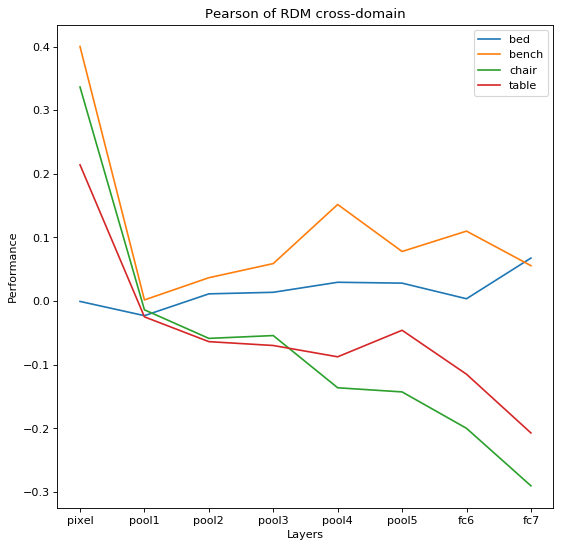

In [71]:
fig = plt.figure(1,  figsize=(8,8), dpi=80, facecolor='w', edgecolor='k')

plt.title("Pearson of RDM cross-domain")
lines = plt.plot(between_domains.transpose())
plt.xlabel('Layers')
plt.ylabel('Performance')

plt.legend(iter(lines), ('bed', 'bench', 'chair', 'table'))

plt.xticks(xrange(0,len(LAYERS) + 1), LAYERS_NM);
